# Data Wrangling with Spark

This is the code used in the previous screencast. Run each code cell to understand what the code does and how it works.

These first three cells import libraries, instantiate a SparkSession, and then read in the data set

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
# from pyspark.sql.functions import udf
# from pyspark.sql.functions import desc
# from pyspark.sql.functions import asc
# from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [3]:
path = "_data/sparkify_log_small.json"
user_log = spark.read.json(path)

# Data Exploration 

The next cells explore the data set.

In [5]:
get_hour = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [6]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [7]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='16')

In [8]:
songs_in_hour = user_log.filter(user_log.page == "Login").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [12]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|    7|
|   1|    6|
|   2|    7|
|   3|    4|
|   4|    4|
|   5|    3|
|   6|    5|
|   7|    6|
|   8|   12|
|   9|    4|
|  10|    6|
|  11|    6|
|  12|    2|
|  13|    5|
|  14|    1|
|  15|    1|
|  16|    4|
|  17|    4|
|  18|   12|
|  19|    7|
+----+-----+
only showing top 20 rows



In [13]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

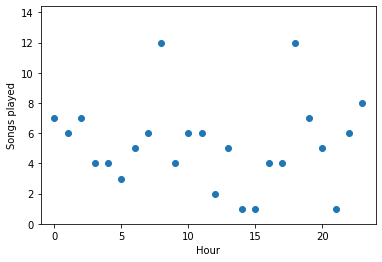

In [14]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [15]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [16]:
user_log_valid.count()

10000

In [17]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [18]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [19]:
user_log_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [20]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   5|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [20]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [21]:
flag_downgrade_event = F.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [22]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [23]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='16', downgraded=0)

### Find which page did user id "" (empty string) NOT visit?

In [26]:
empty_users = user_log_valid.filter(user_log_valid.userId == "") \
                .select(F.col('page') \
                .alias('empty_users')) \
                .dropDuplicates()

all_pages = user_log_valid.select('page').dropDuplicates()

for row in set(all_pages.collect()) - set(empty_users.collect()):
    print(row.page)

Submit Upgrade
Downgrade
NextSong
Help
Save Settings
Home
About
Settings
Error
Logout
Upgrade
Submit Downgrade


In [29]:
empty_users.show()
all_pages.show()

+-----------+
|empty_users|
+-----------+
+-----------+

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|            Home|
|       Downgrade|
|          Logout|
|   Save Settings|
|           About|
|        Settings|
|        NextSong|
|            Help|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



### Find how many female users do we have in the data set?

In [34]:
user_log_valid.filter(user_log_valid.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

462

### Find how many songs were played from the most played artist?

In [36]:
user_log_valid.filter(user_log_valid.page == 'NextSong') \
.select('Artist') \
.groupBy('Artist') \
.agg({'Artist': 'count'}) \
.withColumnRenamed('count(Artist)', 'ArtistPlays') \
.sort(F.desc('ArtistPlays')) \
.show(1)

+--------+-----------+
|  Artist|ArtistPlays|
+--------+-----------+
|Coldplay|         83|
+--------+-----------+
only showing top 1 row



In [31]:
windowval = Window.partitionBy("userId").orderBy(F.desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [32]:
user_log_valid = user_log_valid.withColumn("phase", F.sum("downgraded").over(windowval))

In [41]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

### Find how many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [44]:
function = F.udf(lambda x : int(x == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userId') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

our_count = user_log_valid.filter((user_log_valid.page == 'NextSong') | (user_log_valid.page == 'Home')) \
    .select('userId', 'page', 'ts') \
    .withColumn('visitingHome', function(F.col('page'))) \
    .withColumn('visitingTime', F.sum('visitingHome').over(user_window))

our_count.filter((our_count.page == 'NextSong')) \
    .groupBy('userId', 'visitingTime') \
    .agg({'visitingTime':'count'}) \
    .agg({'count(visitingTime)':'avg'}).show()

+------------------------+
|avg(count(visitingTime))|
+------------------------+
|       6.898347107438017|
+------------------------+



In [45]:
our_count.show()

+------+--------+-------------+------------+------------+
|userId|    page|           ts|visitingHome|visitingTime|
+------+--------+-------------+------------+------------+
|  1436|NextSong|1513783259284|           0|           0|
|  1436|NextSong|1513782858284|           0|           0|
|  2088|    Home|1513805972284|           1|           1|
|  2088|NextSong|1513805859284|           0|           1|
|  2088|NextSong|1513805494284|           0|           1|
|  2088|NextSong|1513805065284|           0|           1|
|  2088|NextSong|1513804786284|           0|           1|
|  2088|NextSong|1513804555284|           0|           1|
|  2088|NextSong|1513804196284|           0|           1|
|  2088|NextSong|1513803967284|           0|           1|
|  2088|NextSong|1513803820284|           0|           1|
|  2088|NextSong|1513803651284|           0|           1|
|  2088|NextSong|1513803413284|           0|           1|
|  2088|NextSong|1513803254284|           0|           1|
|  2088|NextSo